In [1]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm
import import_ipynb
from util import utils

# 环境

In [2]:
env = utils.CartPoleEnv()
env.reset()

array([-0.01867732, -0.04304932,  0.03667076,  0.02323733], dtype=float32)

# 算法定义

## 策略网络

In [3]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)

## 价值网络

In [4]:
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

## PPO类（离散动作环境）

In [5]:
class PPO:
    ''' PPO算法，采用截断方式 '''
    name = "PPO"
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, training_rounds, eps, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.training_rounds = training_rounds  # 一条序列的数据用来训练轮数
        self.eps = eps  # PPO中截断范围的参数
        self.device = device

    def take_action(self, state):
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(np.array(transition_dict['states']),
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(np.array(transition_dict['next_states']),
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)
        advantage = utils.compute_gae(self.gamma, self.lmbda,
                                               td_delta.cpu()).to(self.device)
        old_log_probs = torch.log(self.actor(states).gather(1,
                                                            actions)).detach()

        for _ in range(self.training_rounds):
            log_probs = torch.log(self.actor(states).gather(1, actions))
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps,
                                1 + self.eps) * advantage  # 截断
            actor_loss = torch.mean(-torch.min(surr1, surr2))  # PPO损失函数
            critic_loss = torch.mean(
                F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

    def play(self, env, update=False, show=False):
        episode_return = 0
        transition_dict = {
            'states': [], 
            'actions': [], 
            'next_states': [], 
            'rewards': [], 
            'dones': []
        }
        state = env.reset()
        done = False
        while not done:
            action = agent.take_action(state)
            next_state, reward, done = env.step(action)
            transition_dict['states'].append(state)
            transition_dict['actions'].append(action)
            transition_dict['next_states'].append(next_state)
            transition_dict['rewards'].append(reward)
            transition_dict['dones'].append(done)
            state = next_state
            episode_return += reward
            if show:
                display.clear_output(wait=True)
                env.show()
        if update: 
            agent.update(transition_dict)
        return episode_return

# 初始化

In [6]:
torch.manual_seed(0)

In [7]:
state_dim = env.observation_space.shape[0]
hidden_dim = 128
action_dim = env.action_space.n
actor_lr = 1e-3
critic_lr = 1e-2
lmbda = 0.95
training_rounds = 10
eps = 0.2
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,
            training_rounds, eps, gamma, device)

In [8]:
num_episodes = 500
epochs = 10

# 玩一局游戏（训练前）

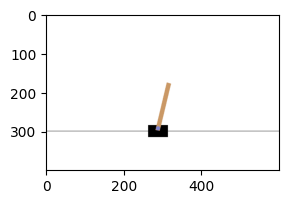

回报：21.0


In [9]:
episode_return = agent.play(env, update=False, show=True)
print("回报：{}".format(episode_return))

# 算法训练

## 训练过程

In [10]:
def train(env, agent, num_episodes, epochs):
    return_list = [] # 记录每一条序列的回报
    update = True
    show = False
    for i in range(epochs): # 显示epochs个进度条
        with tqdm(total=int(num_episodes / epochs), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / epochs)):  # 每个进度条的序列数
                episode_return = agent.play(env, update, show)
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                    pbar.set_postfix({
                        'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return': '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list

In [11]:
return_list = train(env, agent, num_episodes=num_episodes, epochs=epochs)

<string>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
Iteration 9: 100%|████████████████████████████████████████| 50/50 [05:00<00:00,  6.00s/it, episode=500, return=500.000]


## 训练结果

### 训练回报

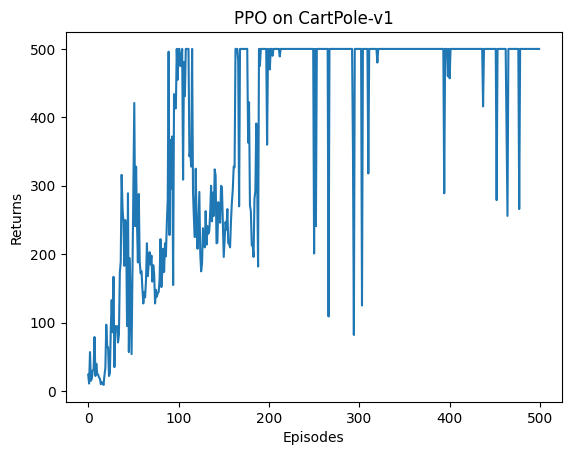

In [12]:
utils.show_return(return_list, agent, env)

### 移动平均训练回报

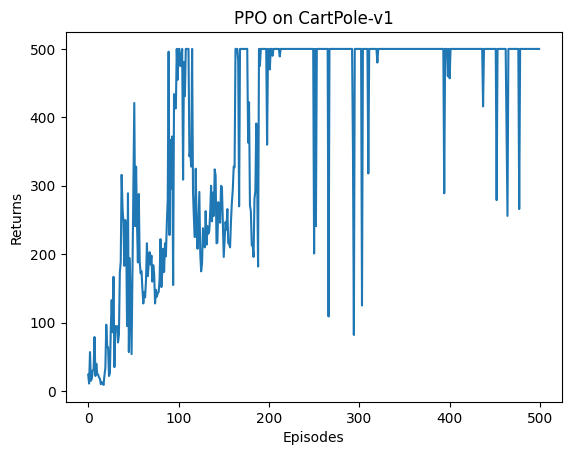

In [13]:
mv_return = utils.moving_average(return_list, 9)
utils.show_return(return_list, agent, env)

# 再玩一局游戏（训练后）

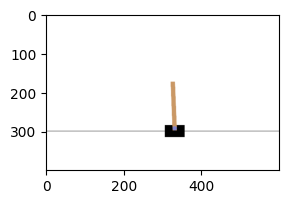

回报：500.0


In [14]:
episode_return = agent.play(env, update=False, show=True)
print("回报：{}".format(episode_return))